In [0]:
from google.colab import drive
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


import lightgbm as lgb
import xgboost
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline  
#from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [39]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_pickle('./gdrive/My Drive/Colab/kaggle/data.pkl')

In [0]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 45 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
usd_rub                                 float16
city_code                               int8
type_of_shop                            int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_shop_first_sale                    int8
item_first_sale                         int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date

In [44]:
data.head()

date_block_num  shop_id  item_id  ...  days  holidays  school_holidays
0              12        2       27  ...    31        14               10
1              12        2       30  ...    31        14               10
2              12        2       31  ...    31        14               10
3              12        2       32  ...    31        14               10
4              12        2       33  ...    31        14               10

[5 rows x 45 columns]

In [34]:
del data; gc.collect()

633

# XGBoost

## Baseline

In [0]:
# Baseline
model = xgboost.XGBRegressor()

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.16359	validation_1-rmse:1.12931
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.12685	validation_1-rmse:1.10254
[2]	validation_0-rmse:1.09564	validation_1-rmse:1.07989
[3]	validation_0-rmse:1.06908	validation_1-rmse:1.06135
[4]	validation_0-rmse:1.04648	validation_1-rmse:1.04611
[5]	validation_0-rmse:1.02646	validation_1-rmse:1.03269
[6]	validation_0-rmse:1.01005	validation_1-rmse:1.0215
[7]	validation_0-rmse:0.995254	validation_1-rmse:1.01168
[8]	validation_0-rmse:0.98258	validation_1-rmse:1.00347
[9]	validation_0-rmse:0.972204	validation_1-rmse:0.996893
[10]	validation_0-rmse:0.963165	validation_1-rmse:0.991039
[11]	validation_0-rmse:0.955527	validation_1-rmse:0.986468
[12]	validation_0-rmse:0.948954	validation_1-rmse:0.98251
[13]	validation_0-rmse:0.943221	validation_1-rmse:0.978549
[14]	validation_0-rmse:0.93822	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

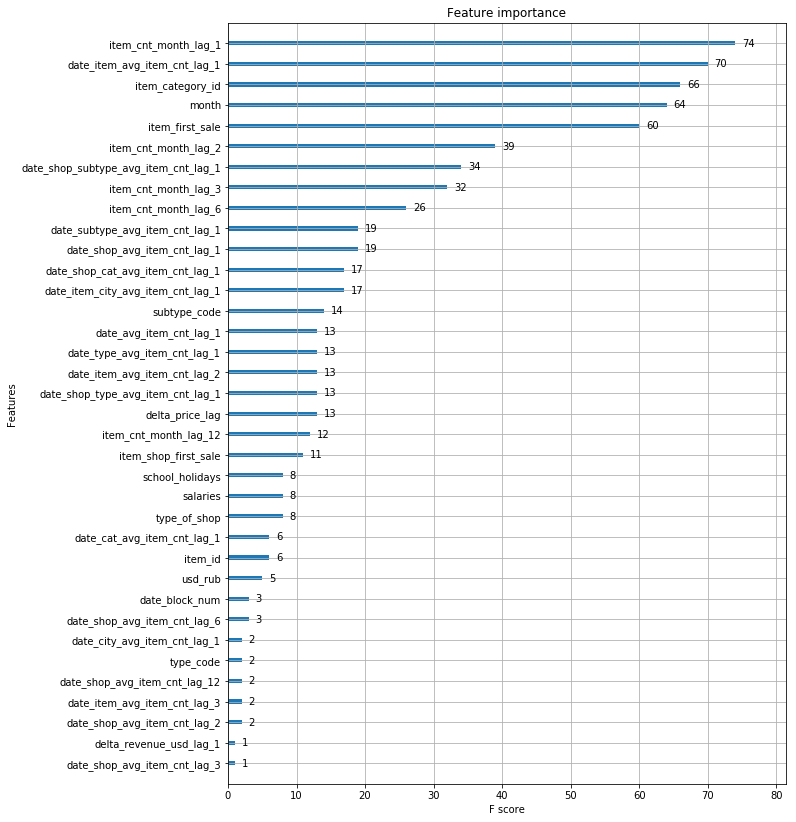

In [0]:
plot_features(model, (10,14))

### RandomizedSearchCV for xgboost

In [0]:
import xgboost
import pickle
import pandas as pd
from xgboost import XGBRegressor  
import scipy.stats as st

data = pd.read_pickle('./data.pkl')

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)


one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "num_boost_round": st.randint(1,1000),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive}

xgbreg = XGBRegressor(eval_metric = 'rmse', eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True, early_stopping_rounds=10, n_jobs=8) 

from sklearn.model_selection import RandomizedSearchCV

randomized_mse = RandomizedSearchCV(estimator=xgbreg, param_distributions=params, n_iter=30, scoring='neg_mean_squared_error', cv=3, verbose=3)
randomized_mse.fit(X_train, Y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", randomized_mse.best_score_)


### XGBoost Model 1

In [0]:
import xgboost
import pickle
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor

data = pd.read_pickle('./data.pkl')

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
print("Data Done")


model = xgboost.XGBRegressor(
    colsample_bytree=0.8836032642344559,
    gamma=9.244170610604531,
    learning_rate=0.17215789344942337,
    max_depth=7,
    min_child_weight=23.272915813017278,
    num_boost_round=922,
    reg_alpha=50.11768671610619,
    subsample=0.8976585444371051,
    n_jobs=8)


model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True,
    early_stopping_rounds = 10)

# And for ensambling :)
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('./xgboost_2_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./xgboost_2_submission.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))
plt.savefig('Xgboost2.png')
#[71]    validation_0-rmse:0.795773      validation_1-rmse:0.905832

### XGBoost Model 2

In [0]:
#Lowest RMSE found:  -0.7377194677724266
import xgboost
import pickle
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor

data = pd.read_pickle('./data.pkl')

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
print("Data Done")


model = xgboost.XGBRegressor(colsample_bytree = 0.82304985233029,
                             gamma = 2.4115005068838835,
                             learning_rate = 0.14552629534600695,
                             max_depth = 8,
                             min_child_weight = 12.213157325885064,
                             num_boost_round = 607,
                             reg_alpha = 51.166989722764335,
                             subsample = 0.9727919967028549,
                             n_jobs=8)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True,
    early_stopping_rounds = 10)

# And for ensambling :)
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('./xgboost_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./xgboost_submission.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))
plt.savefig('Xgboost.png')

#[46]    validation_0-rmse:0.79519       validation_1-rmse:0.905585

# LightGBM

In [0]:
import xgboost
import pickle
import pandas as pd

data = pd.read_pickle('./data.pkl')

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
print("Data Done")

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

clf = lgb.LGBMRegressor()

param_grid ={'n_estimators':sp_randint(3000, 15000),
             'num_leaves': sp_randint(100, 250), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate':[0.001,0.01, 0.1, 0.2, 0.3]}

fit_params = {'eval_metric': 'rmse',
              'early_stopping_rounds': 30,
              'eval_set': [(X_valid, Y_valid)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=100,
                            n_jobs=8, verbose=2, cv=3,
                            fit_params=fit_params,
                            scoring='neg_mean_squared_error', refit=False, random_state=42)
print("Randomized search..")

rs_clf.fit(X_train, Y_train)


best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

In [0]:

Best score: -0.7302970009466717
Best params: 
colsample_bytree: 0.5719247512769706
min_child_samples: 413
min_child_weight: 10.0
n_estimators: 4877
num_leaves: 75
reg_alpha: 7
reg_lambda: 1
subsample: 0.30164841012150784


Best score: -0.7275709333233061
Best params: 
colsample_bytree: 0.5870266456536466
min_child_samples: 489
min_child_weight: 10.0
n_estimators: 10000
num_leaves: 111
reg_alpha: 2
reg_lambda: 20
subsample: 0.22505063396444688
  

Best score: -0.7336704712274175
Best params: 
colsample_bytree: 0.7554487413172255
min_child_samples: 230
min_child_weight: 1
n_estimators: 10000
num_leaves: 150
reg_alpha: 10
reg_lambda: 10
subsample: 0.5603994015756344
  
  
Best score: -0.7325635072700357
Best params: 
colsample_bytree: 0.899465584480253
learning_rates: 3
min_child_samples: 485
min_child_weight: 1
n_estimators: 10000
num_leaves: 157
reg_alpha: 7
reg_lambda: 10
subsample: 0.5455560149136927
  
Best score: -0.7329229264852707
Best params:
colsample_bytree: 0.45215217285245424
learning_rate: 0.01
min_child_samples: 210
min_child_weight: 1000.0
n_estimators: 9891
num_leaves: 182
reg_alpha: 100
reg_lambda: 10
subsample: 0.4904658371189081


In [0]:

import lightgbm as lgb


train_data = lgb.Dataset(data=X_train, label=Y_train)
valid_data = lgb.Dataset(data=X_valid, label=Y_valid)

    
params = {"objective" : "regression",
          "metric" : "rmse",
          'n_estimators':10000,
          'min_child_weight' :10.0,
          'colsample_bytree' :0.5870266456536466,
          'min_child_samples' :489,
          'early_stopping_rounds':100,
          "num_leaves" :111,
          'reg_alpha' :2,
          'reg_lambda' :20,
          'subsample' : 0.225050633964446880,
          "learning_rate" : 0.01}
    
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=10) 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 1.14131	valid_1's rmse: 1.10161
[20]	training's rmse: 1.1	valid_1's rmse: 1.07168
[30]	training's rmse: 1.06276	valid_1's rmse: 1.04514
[40]	training's rmse: 1.03139	valid_1's rmse: 1.02323
[50]	training's rmse: 1.00386	valid_1's rmse: 1.0044
[60]	training's rmse: 0.979548	valid_1's rmse: 0.988301
[70]	training's rmse: 0.958485	valid_1's rmse: 0.975111
[80]	training's rmse: 0.9404	valid_1's rmse: 0.964047
[90]	training's rmse: 0.924679	valid_1's rmse: 0.954799
[100]	training's rmse: 0.910894	valid_1's rmse: 0.947284
[110]	training's rmse: 0.899042	valid_1's rmse: 0.940628
[120]	training's rmse: 0.889224	valid_1's rmse: 0.935305
[130]	training's rmse: 0.880407	valid_1's rmse: 0.930929
[140]	training's rmse: 0.872437	valid_1's rmse: 0.927261
[150]	training's rmse: 0.86551	valid_1's rmse: 0.92439
[160]	training's rmse: 0.859292	valid_1's rmse: 0.922421
[170]	training's rmse: 0.854103	valid_1's rmse: 0.920

In [0]:
Y_test = lgb_model.predict(X_test).clip(0, 20)

test = pd.read_csv('./gdrive/My Drive/Colab/kaggle/test.csv').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/lgbm_submission.csv', index=False)

In [0]:
# And for ensambling :)
Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_submission.csv', index=False)

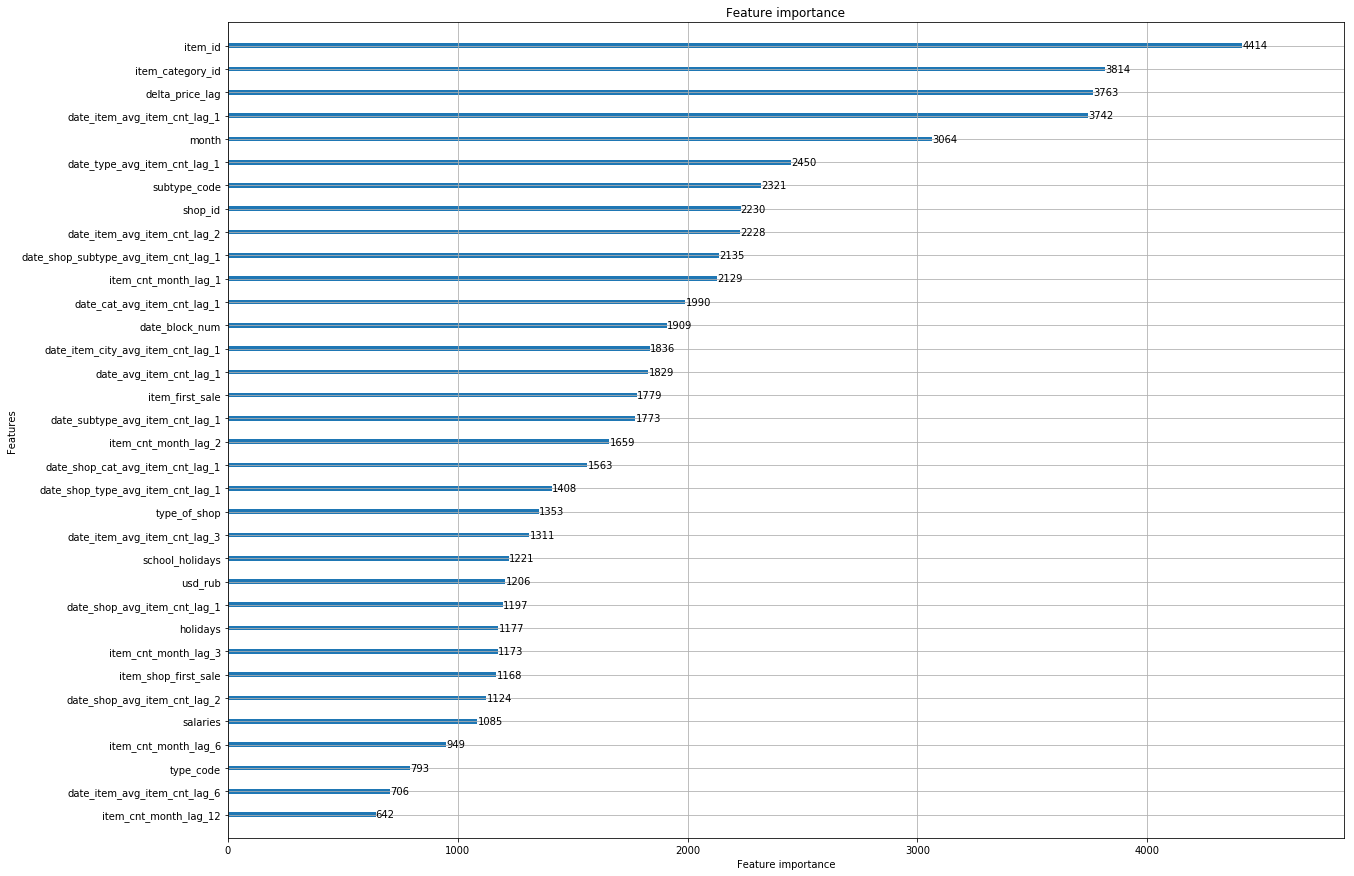

In [0]:
lgb.plot_importance(lgb_model, max_num_features=34, figsize=(20,15))
plt.show()


In [0]:

import lightgbm as lgb


train_data = lgb.Dataset(data=X_train, label=Y_train)
valid_data = lgb.Dataset(data=X_valid, label=Y_valid)

    
params = {"objective" : "regression",
          "metric" : "rmse",
          'early_stopping_rounds':100,
          "colsample_bytree": 0.45215217285245424,
          "learning_rate": 0.01,
          "min_child_samples": 210,
          "min_child_weight": 1000.0,
          "n_estimators": 9891,
          "num_leaves": 182,
          "reg_alpha": 100,
          "reg_lambda": 10,
          "subsample": 0.4904658371189081,
          "learning_rate" : 0.01}


    
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=10,) 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 1.14387	valid_1's rmse: 1.10402
[20]	training's rmse: 1.10346	valid_1's rmse: 1.07476
[30]	training's rmse: 1.06767	valid_1's rmse: 1.04839
[40]	training's rmse: 1.03697	valid_1's rmse: 1.02544
[50]	training's rmse: 1.00993	valid_1's rmse: 1.00608
[60]	training's rmse: 0.986308	valid_1's rmse: 0.989181
[70]	training's rmse: 0.966365	valid_1's rmse: 0.975486
[80]	training's rmse: 0.947776	valid_1's rmse: 0.963219
[90]	training's rmse: 0.932259	valid_1's rmse: 0.952929
[100]	training's rmse: 0.918864	valid_1's rmse: 0.944197
[110]	training's rmse: 0.906696	valid_1's rmse: 0.936807
[120]	training's rmse: 0.896922	valid_1's rmse: 0.930506
[130]	training's rmse: 0.887727	valid_1's rmse: 0.925318
[140]	training's rmse: 0.880112	valid_1's rmse: 0.921233
[150]	training's rmse: 0.873129	valid_1's rmse: 0.917698
[160]	training's rmse: 0.866877	valid_1's rmse: 0.914765
[170]	training's rmse: 0.861547	valid_1's rm

In [0]:
Y_test = lgb_model.predict(X_test).clip(0, 20)

test = pd.read_csv('./gdrive/My Drive/Colab/kaggle/test.csv').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/lgbm_2_submission.csv', index=False)

In [0]:
# And for ensambling :)
Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_2_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_2_submission.csv', index=False)

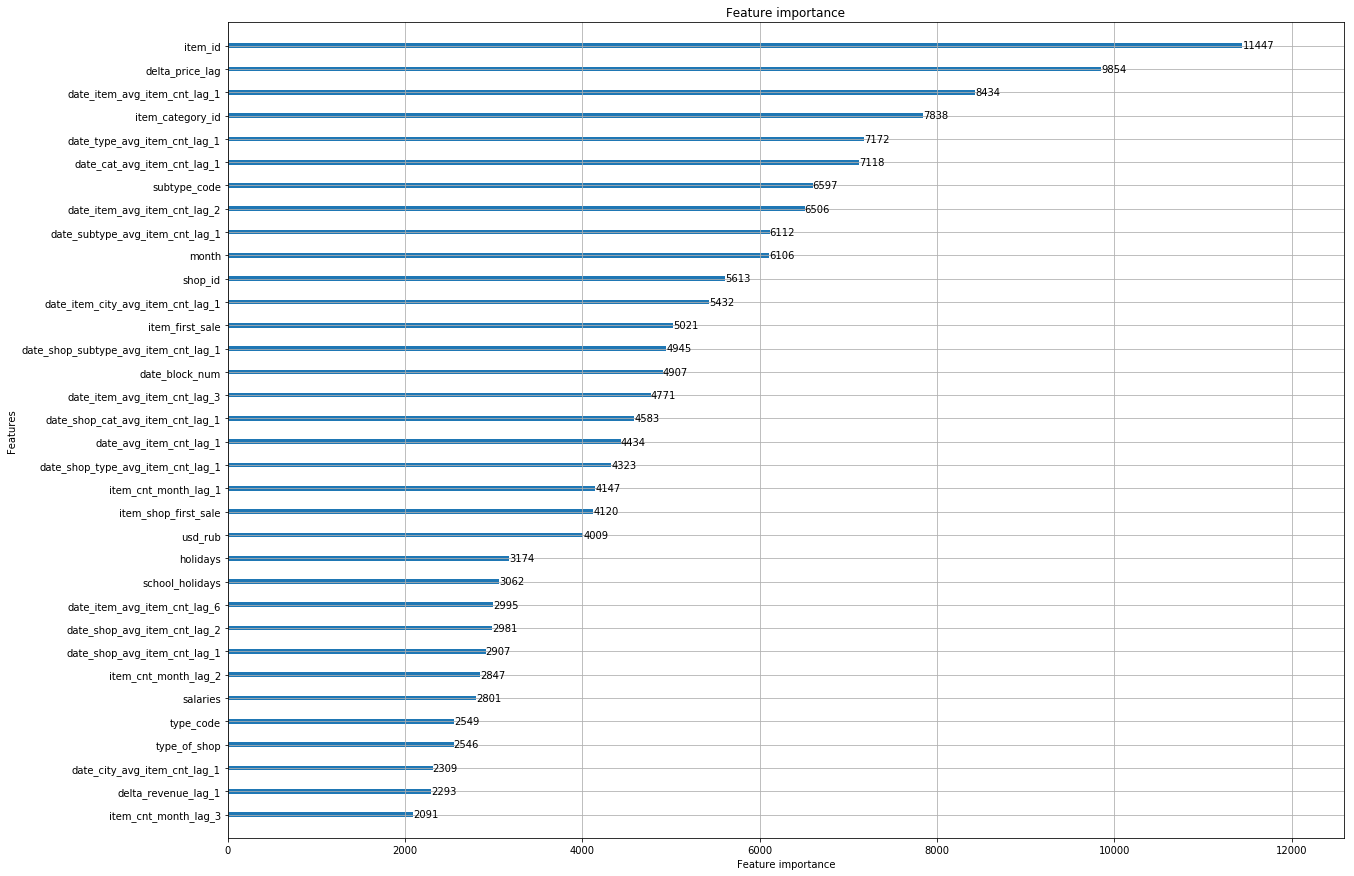

In [0]:
lgb.plot_importance(lgb_model, max_num_features=34, figsize=(20,15))
plt.show()

In [0]:
import lightgbm as lgb


train_data = lgb.Dataset(data=X_train, label=Y_train)
valid_data = lgb.Dataset(data=X_valid, label=Y_valid)

    
params = {"objective" : "regression",
          "metric" : "rmse",
          'n_estimators':10000,
          'early_stopping_rounds':100,
          "num_leaves" : 200, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
          "feature_fraction" : 0.3, "bagging_seed" : 0}
    
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=10) 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 1.14545	valid_1's rmse: 1.10616
[20]	training's rmse: 1.10834	valid_1's rmse: 1.08022
[30]	training's rmse: 1.0724	valid_1's rmse: 1.05406
[40]	training's rmse: 1.04356	valid_1's rmse: 1.03412
[50]	training's rmse: 1.01446	valid_1's rmse: 1.01409
[60]	training's rmse: 0.989607	valid_1's rmse: 0.998111
[70]	training's rmse: 0.967737	valid_1's rmse: 0.983686
[80]	training's rmse: 0.948033	valid_1's rmse: 0.971792
[90]	training's rmse: 0.930087	valid_1's rmse: 0.960931
[100]	training's rmse: 0.914758	valid_1's rmse: 0.951786
[110]	training's rmse: 0.900938	valid_1's rmse: 0.944113
[120]	training's rmse: 0.889406	valid_1's rmse: 0.937725
[130]	training's rmse: 0.878566	valid_1's rmse: 0.931759
[140]	training's rmse: 0.869212	valid_1's rmse: 0.927198
[150]	training's rmse: 0.860801	valid_1's rmse: 0.923608
[160]	training's rmse: 0.853289	valid_1's rmse: 0.920843
[170]	training's rmse: 0.846643	valid_1's rms

In [0]:
# And for ensambling :)
Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_3_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_3_submission.csv', index=False)

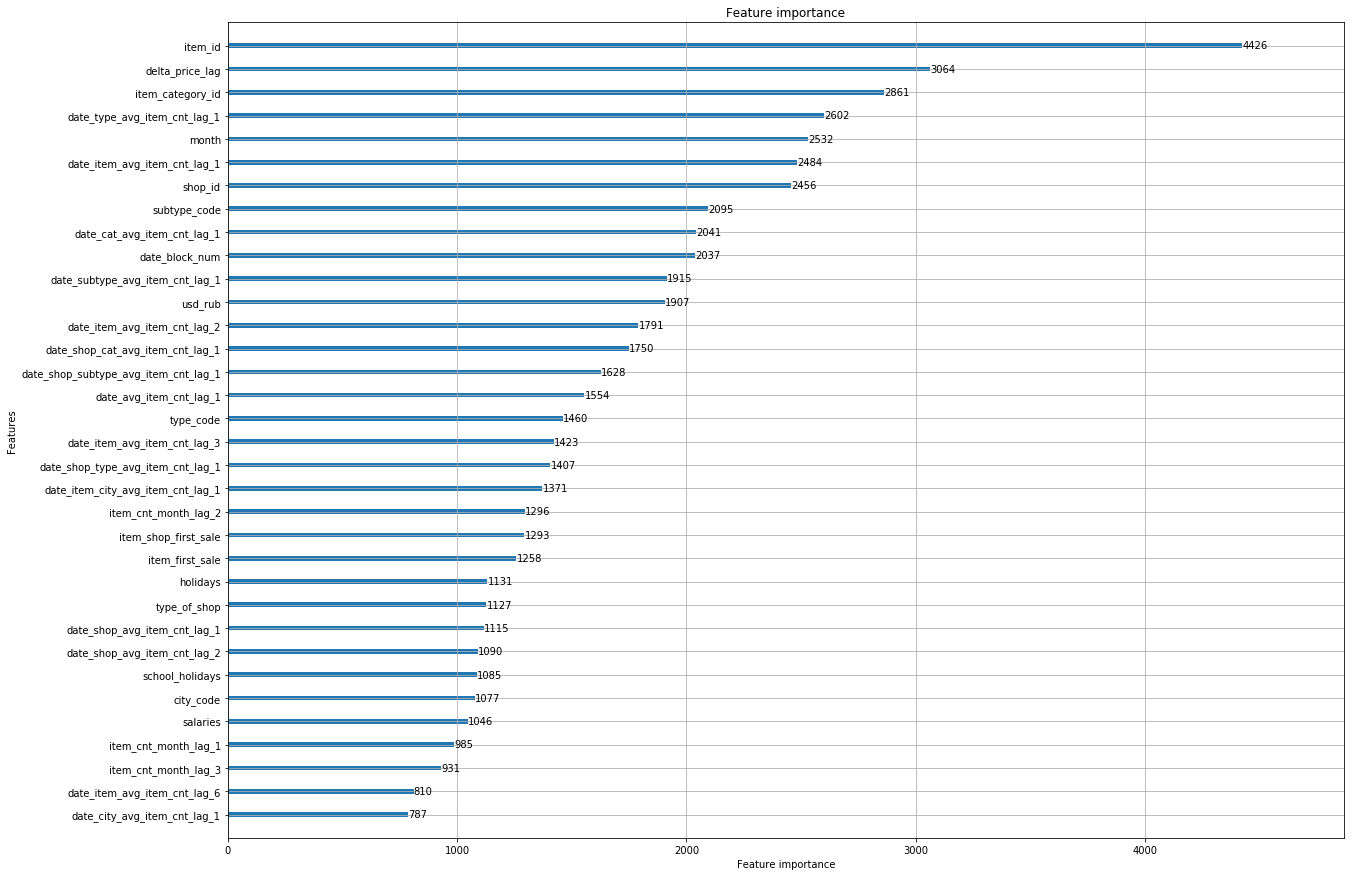

In [0]:
lgb.plot_importance(lgb_model, max_num_features=34, figsize=(20,15))
plt.show()

### Catboost

In [7]:
!pip install catboost

     |████████████████████████████████| 60.6MB 619kB/s 


In [35]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.03,
                          task_type='GPU',
                          eval_metric='RMSE',
                          verbose = 100,
                          max_ctr_complexity = 4,
                          depth=6)
# Fit model
model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), plot_feature_importance=True)


Y_pred = model.predict(X_train).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('Catboost validation rmse: ',rmse)


X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/cat_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/cat_submission.csv', index=False)

0:	learn: 1.2083744	test: 1.1547684	best: 1.1547684 (0)	total: 73ms	remaining: 2m 26s
100:	learn: 0.8862234	test: 0.9420079	best: 0.9420079 (100)	total: 4.6s	remaining: 1m 26s
200:	learn: 0.8642109	test: 0.9288011	best: 0.9288011 (200)	total: 9.32s	remaining: 1m 23s
300:	learn: 0.8502225	test: 0.9171424	best: 0.9171424 (300)	total: 14.1s	remaining: 1m 19s
400:	learn: 0.8412974	test: 0.9119498	best: 0.9119498 (400)	total: 18.8s	remaining: 1m 14s
500:	learn: 0.8347597	test: 0.9085389	best: 0.9083579 (499)	total: 23.5s	remaining: 1m 10s
600:	learn: 0.8293427	test: 0.9056055	best: 0.9055906 (591)	total: 28.2s	remaining: 1m 5s
700:	learn: 0.8246977	test: 0.9038186	best: 0.9035680 (689)	total: 32.9s	remaining: 1m
800:	learn: 0.8211549	test: 0.9019546	best: 0.9019543 (798)	total: 37.5s	remaining: 56.2s
900:	learn: 0.8180657	test: 0.9018946	best: 0.9018819 (803)	total: 42.3s	remaining: 51.5s
1000:	learn: 0.8148808	test: 0.9004601	best: 0.9004323 (994)	total: 47s	remaining: 46.9s
1100:	learn: 0

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Catboost validation rmse:  0.7953244684692244


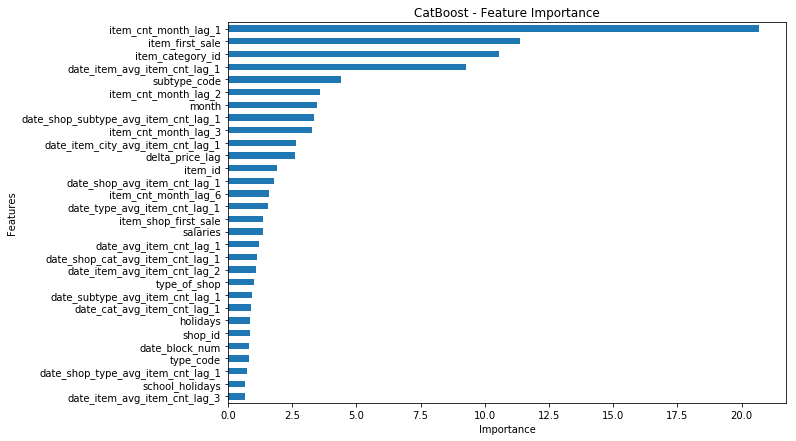

In [37]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [0]:
#to kill VM
!kill -9 -1